In [177]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date, time
import pytz

import requests, zipfile, io

#%matplotlib notebook

In [178]:
# capex/opex shift including substitution once in 10 years for 20 years project

THIS_YEAR = 2022

# IRR rate used throughout the project
RATE_IRR = 0.12
IRR_RATE = 0.12

# Assume long term IRS average
RATE_INFLATION = 0.03

# federal taxation rate
rate_tax_fed = 0.21

# state taxation rate
rate_tax_state = 0.075

RATE_IRS = 0.03

PROJECT_LIFETIME = 20

In [179]:
def capex(pv_power, bat_capacity, bat_c_factor, lyser_power, tariff, year):
    
    grid_capex = 0
    capex = 0
    grid_opex_year = 0
    
    ################################
    ######
    ######       GRID
    ######
    ################################
    
    # handle grid connection 
    connection = 100000
    
    connected_power = bat_c_factor*bat_capacity + pv_power
        
    if(connected_power > 20000):
        connection = 250000
    
    # minimal 60kV transformer
    transformer = 3000000
        
        
    # Undergrounded connection, country average
    # 3.5 miles 69kV to the transmission station
    # labor cost included
    # https://www.power-grid.com/td/underground-vs-overhead-power-line-installation-cost-comparison/#gref
    land = 280000*3.5
    
    
    grid_capex = grid_capex + connection + transformer + land
        
    grid_om = 1.015
    grid_insurance = 1.015
    grid_labor = 1.5
    project_overhead = 1.1
        
    grid_capex = grid_capex*grid_insurance*grid_om*grid_labor*project_overhead
    
    if (tariff == 'CAISO'):
        capex = grid_capex
        # metering
        opex_year = 58.30*365
        
    elif (tariff == 'PG&E WDAT'):
        # Only Labor, quoted according to TJ's proposal
        capex = 484000/3
        
        #Interconnection + service initiation + processing fee
        # 10 k is a study fee
        capex = capex + 5400 + 10000

        # deposit 50 k + 1 k for each MW of power
        # https://www.pge.com/includes/docs/pdfs/shared/customerservice/nonpgeutility/electrictransmission/tariffs/PGE_Wholesale_Distribution_Tariff.pdf
        capex = capex + min(50000 + (connected_power/1000)*1000,250000) 

        # 4.23.2.2 -- network upgrade fee
        # Increases to 7'500'000 once we produce more than 20 MW
        capex = capex + 20000
      
        # distribution upgrades
        capex = capex + 20000*(connected_power/1000)

        # 4.23.3.2 Financial responsibility (deposit). 15'000'000 if we are produce more than 20MW
      
        if (self.connected_power < 20000):
            capex = capex + 1000000
        else:
            capex = capex + 15000000

        # 3. COST OF OWNERSHIP CHARGE
        # We have the secondary voltage right now
        # connection fee
        grid_opex_year = 5728*12
        
        # cost of ownership
        opex_year = 0.0048*12*grid_capex
        # metering
        opex_year = 58.30*365
        
        # reset values
        grid_capex = capex
        capex = 0
        
    else: # PG&E B-20
        # price for metering
        grid_opex = 58.30*365
        grid_capex = 0
    
    grid_capex = np.round(grid_capex*((1+RATE_IRS)**(year - 2022)),2)
    
    print("Grid CaPex", grid_capex)
    
    ################################
    ######
    ######       BATTERY
    ######
    ################################
    
    bat_capacity_at_replacement = 0.8
    bat_om_year_rate = 0.015
    bat_overhead = 0.1
    bat_warranty_rate_year = 0.01
    bat_cost_drop_rate = 0.03
    bat_degradation_year = 0.03
    #tax_credit_rate = 0.26
    
    
    # Capex include installation and connection costs
    bat_capex = 0
    unit_capex = 0
    if (bat_capacity < 100):
        unit_capex = 2800
        bat_capex = 2800*bat_capacity
        
    elif(bat_capacity < 2000):
        unit_capex = 1200
        bat_capex = 1200*bat_capacity
        
    else: 
        unit_capex = 900
        bat_capex = 900*bat_capacity

    time_to_change = 7 #self.fce_max/(350*self.fce_day_max)
    i=1; 
    
    while (i < (PROJECT_LIFETIME / time_to_change)):
        #print(i, self.lifetime / time_to_change)
        # price to buy a new battery
        bat_capex = bat_capex + (unit_capex*bat_capacity)*((1-bat_cost_drop_rate)**(i*time_to_change))

        # price to sell the old battery. 50% discount assumed
        bat_capex = bat_capex -(unit_capex*bat_capacity)*(((1 - bat_degradation_year)*(1-bat_cost_drop_rate))**(i*time_to_change))
        i = i+1

    # take annual charges into account
    # OM and Warranty
    # Inflation vs IRR
    # As investment, 
    bat_capex = bat_capex + bat_capex*(bat_warranty_rate_year + bat_om_year_rate)*(1-(1-RATE_IRR)**PROJECT_LIFETIME)/(RATE_IRR)
 
    # respect overhead
    bat_capex = np.round(bat_capex*(1+bat_overhead)*((1-bat_cost_drop_rate)**(year-2022)),2)
    print("Battery MW vs capex", bat_capacity, bat_capex)

    #self.capex = self.get_capex(self.connnected_capacity)
    #self.om_year = om_year_rate*self.capex # annual
    
    ################################
    ######
    ######       BATTERY
    ######
    ################################
    
    
    pv_om_year_rate = 0.015
    pv_overhead = 0.1
    pv_warranty_rate_year = 0.01
    pv_degradation_year = 0.005
    pv_cost_drop_rate = 0.03
    pv_overhead = 0.1
    
    unit_capex = 0
    if (pv_power < 200):
        unit_capex = 2400
    elif(pv_power > 15000):
        unit_capex = 1000
    else: 
        unit_capex = 1400    

    pv_capex = unit_capex*pv_power

    # we do change the battery once in 7 years now
    # should be done based on actual degradation rate 

    time_to_change = 25 #self.fce_max/(350*self.fce_day_max)
    i=1; 
    
    while (i < (PROJECT_LIFETIME / time_to_change)):
        #print(i, self.lifetime / time_to_change)
        # price to buy a new battery
        pv_capex = pv_capex + (unit_capex*pv_power)*((1-pv_cost_drop_rate)**(i*time_to_change))

        # price to sell the old battery. 50% discount assumed
        pv_capex = pv_capex - (unit_capex*pv_power)*(((1 - pv_year)*(1-pv_cost_drop_rate))**(i*time_to_change))
        i = i+1

    # take annual charges into account
    # OM and Warranty
    # Inflation vs IRR
    # Discount to fulfil premium requirements on the rate of return
    #print(pv_capex)
    z = 1+(pv_warranty_rate_year + pv_om_year_rate)*(1-((1-RATE_IRR)**PROJECT_LIFETIME))/(RATE_IRR)
    pv_capex = pv_capex*z
 
    # respect overhead
    pv_capex = np.round(pv_capex*(1+pv_overhead)*((1-pv_cost_drop_rate)**(year-2022)),2)
    print("Solar MW vs capex", pv_power, pv_capex)

    
    ################################
    ######
    ######       ELECTROLYSER
    ######
    ################################
    
    
    
    unit_capex = 0
    lyser_om_year_rate = 0.015
    lyser_overhead = 0.1
    lyser_warranty_rate_year = 0.01
    lyser_installation_rate = 0.5
    lyser_degradation_year = 0.023 
    lyser_cost_drop_rate = 0.05
    
    if (lyser_power < 100):
        unit_capex = 1200
    elif(lyser_power < 400):
        unit_capex = 900
    elif(lyser_power < 800):
        unit_capex = 800
    elif(lyser_power < 1000):
        lyser_capex = 750
    elif(lyser_power < 2000):
        lyser_capex = 650
    elif(lyser_power < 3000):
        unit_capex = 600
    elif(lyser_power < 5000):
        unit_capex = 550
    else: 
        unit_capex = 500    

    lyser_capex = lyser_power*unit_capex
    # 35 % for mounting, contingency, etc
    # 35 % for storage https://www.hydrogen.energy.gov/pdfs/review20/st100_houchins_2020_o.pdf
    lyser_capex = 1.7 * unit_capex*lyser_power

    time_to_change = 10.5 #self.fce_max/(350*self.fce_day_max)
    i=1; 
    while (i < (PROJECT_LIFETIME / time_to_change)):
        #print(i, self.lifetime / time_to_change)
        # price to buy a new battery
        lyser_capex = lyser_capex + (unit_capex*lyser_power)*((1-lyser_cost_drop_rate)**(i*np.round(time_to_change,0)))

        # price to sell the old battery. 50% discount assumed
        lyser_capex = lyser_capex - (unit_capex*lyser_power)*(((1 - lyser_degradation_year)*(1-lyser_cost_drop_rate))**(i*np.round(time_to_change,0)))
        i = i+1

    
    # Inflation vs IRR
    lyser_capex = lyser_capex + lyser_capex*(lyser_warranty_rate_year + lyser_om_year_rate)*(1-(1-RATE_IRR)**PROJECT_LIFETIME)/(RATE_IRR)
 
    # respect overhead
    lyser_capex = np.round(lyser_capex*(1+lyser_overhead)*((1-lyser_cost_drop_rate)**(year - 2022)),2)
    print("Lyser MW vs capex", lyser_power, lyser_capex)
    
    return lyser_capex+pv_capex+bat_capex+grid_capex


## Get PV power, CAISO prices, daily demand, CO2 rate from CSV

In [180]:
df_pv = pd.read_csv('pv_power.csv', index_col=0)
df_co2_rate = pd.read_csv('CO2_rate.csv', index_col=0)

df_CAISO_energy_price = pd.read_csv('caiso_09_2021-08_2022_mean_month-to-month.csv', index_col=0)

df_PGE_energy_price = pd.read_csv('B-20_energy_price.csv', index_col=0, parse_dates=True)
df_peak_rule = pd.read_csv('B-20_peak_rule.csv', index_col=0, parse_dates=True)
df_part_peak_rule = pd.read_csv('B-20_part-peak_rule.csv', index_col=0, parse_dates=True)

In [181]:
class scheduler_calculator():
    def __init__(self, price_provider, pv_csv, co2_rate_csv, energy_price_csv):
        self.price_provider = price_provider
        
        self.df_pv = pd.read_csv('pv_power.csv', index_col=0)
        self.df_co2_rate = pd.read_csv('CO2_rate.csv', index_col=0)
        
        if self.price_provider == "CAISO":
            self.df_energy_price = pd.read_csv('caiso_09_2021-08_2022_mean_month-to-month.csv', index_col=0)
        else:
            self.df_energy_price = pd.read_csv('B-20_energy_price.csv', index_col=0, parse_dates=True)
        
        df_peak_rule = pd.read_csv('B-20_peak_rule.csv', index_col=0, parse_dates=True)
        df_part_peak_rule = pd.read_csv('B-20_part-peak_rule.csv', index_col=0, parse_dates=True)
        
        self.TIMEZONE = pytz.timezone("US/Pacific")
        
        INTERVALS_PER_HOUR = 12
        INTERVALS_PER_DAY = 24 * INTERVALS_PER_HOUR
        N_DAYS = 31

        self.n_intervals = N_DAYS * INTERVALS_PER_DAY
        
        self.BAT_DEGRADATION_PER_CYCLE = 5e-5
        self.BAT_CHARGE_EFF = 0.98 * 0.95
        self.BAT_SELF_DISCHARGE_FACTOR = 0.99999153 # per 5 min interval

        # Battery dispatch specs

        self.BAT_MIN_SOC = 0.15
        self.BAT_MAX_SOC = 0.95
        self.BAT_INIT_SOC = 0.5

        # PENALTIES

        self.H2_KWH_PER_KG = 58

        self.PV_LOSS_FACTOR = 0.86 # from SAM

        self.PRICE_MAX_DEMAND = 28.04
        self.PRICE_MAX_PEAK_DEMAND = 3.13
        self.PRICE_MAX_PART_PEAK_DEMAND = 0.90
        

In [182]:
# TIME SPECS

INTERVALS_PER_HOUR = 12
INTERVALS_PER_DAY = 24 * INTERVALS_PER_HOUR
N_DAYS = 31

n_intervals = N_DAYS * INTERVALS_PER_DAY

# BATTERY SPECS
# https://www.electriccarpartscompany.com/163ah-calb-batteries-l173f163b
# charge - POSITIVE, discharge - NEGATIVE

# Battery life specs

BAT_DEGRADATION_PER_CYCLE = 5e-5
BAT_CHARGE_EFF = 0.98 * 0.95
BAT_SELF_DISCHARGE_FACTOR = 0.99999153 # per 5 min interval

# Battery dispatch specs

BAT_MIN_SOC = 0.15
BAT_MAX_SOC = 0.95
BAT_INIT_SOC = 0.5

# LOAD SPECS

#LYZ_SINGLE_POWER_MAX = 20
#LYZ_N = 15
#LYZ_STACK_POWER_MAX = LYZ_SINGLE_POWER_MAX * LYZ_N
#LYZ_STACK_POWER_MIN = 0.6 * LYZ_SINGLE_POWER_MAX
# maximum of five on/off cycles per day, and one on/off cycle per hour

# PENALTIES

H2_KWH_PER_KG = 54

PV_LOSS_FACTOR = 0.86 # from SAM

PRICE_MAX_DEMAND = 28.04
PRICE_MAX_PEAK_DEMAND = 3.13
PRICE_MAX_PART_PEAK_DEMAND = 0.90

## Optimizer

In [183]:
import pyomo.environ as pyomo
from pyomo.util.infeasible import log_infeasible_constraints, log_close_to_bounds
from pyomo.environ import value
from pyomo.opt import SolverStatus, TerminationCondition
import logging

logging.getLogger('pyomo.core').setLevel(logging.ERROR)

def scheduler_CAISO(pv_rated_power, bat_capacity, bat_c_rate, lyz_rated_power, lyz_daily_demand_kg, aim_co2,
              df_energy_price, df_pv, df_co2_rate):
    
    BAT_NOM_C_RATE = bat_c_rate
    BAT_TOTAL_CAPACITY = bat_capacity # kWh
    BAT_NOMINAL_POWER_CHARGE = bat_c_rate * bat_capacity # kW
    bat_capacity_limit_min = BAT_MIN_SOC * BAT_TOTAL_CAPACITY
    bat_capacity_limit_max = BAT_MAX_SOC * BAT_TOTAL_CAPACITY
    BAT_CYCLE_PENALTY = BAT_TOTAL_CAPACITY * 500 / 4000 * 0.2 
    # for 1MWh: CYCLE LIFE (80%) -- 4000; ~$500k capex

    LYZ_POWER_MAX = lyz_rated_power
    LYZ_POWER_MIN = 0.1 * lyz_rated_power
    
    df_daily_h2_demand = pd.DataFrame(columns=['VALUE'])
    for i in range(N_DAYS):
        df_daily_h2_demand.loc[i] = [lyz_daily_demand_kg]
        
    system_power_max = BAT_NOMINAL_POWER_CHARGE + pv_rated_power + lyz_rated_power
        
    # create model
    m = pyomo.ConcreteModel()

    # Sets
    m.times = pyomo.Set(initialize=range(n_intervals))
    m.times_plus_1 = pyomo.Set(initialize=range(n_intervals + 1))
    
    # Parameters
    m.grid_price = pyomo.Param(m.times, initialize=df_energy_price.to_numpy().flatten())                              # USD/kWh
    m.pv_power = pyomo.Param(m.times, initialize=df_pv.to_numpy().flatten() * pv_rated_power * PV_LOSS_FACTOR) # kW (normalized to 100 kW rated power)
    m.lyz_demand_daily = pyomo.Param(m.times, initialize=df_daily_h2_demand.to_numpy().flatten() * H2_KWH_PER_KG)     # kWh
    m.lyz_daily_demand_kg = pyomo.Param(initialize=lyz_daily_demand_kg)
    m.co2_rate = pyomo.Param(m.times, initialize=df_co2_rate.to_numpy().flatten())
    m.BAT_TOTAL_CAPACITY = pyomo.Param(initialize=BAT_TOTAL_CAPACITY)

    # DECISION VARIABLES
    m.grid_power = pyomo.Var(m.times, domain=pyomo.Reals, initialize=0.0, bounds=(-system_power_max, system_power_max))
    m.lyz_power = pyomo.Var(m.times, domain=pyomo.NonNegativeReals, initialize=0.0)

    m.bat_charge = pyomo.Var(m.times_plus_1, domain=pyomo.NonNegativeReals, initialize=0.0)
    m.bat_power = pyomo.Var(m.times, domain=pyomo.Reals, initialize=0.0, bounds=(-BAT_NOMINAL_POWER_CHARGE, BAT_NOMINAL_POWER_CHARGE))
    m.bat_capacity = pyomo.Var(m.times_plus_1, domain=pyomo.NonNegativeReals, initialize=0.0)

    m.bat_power_abs = pyomo.Var(m.times, domain=pyomo.NonNegativeReals, initialize=0.0, bounds=(0, BAT_NOMINAL_POWER_CHARGE))

    # OBJECTIVE

    cost = sum((
        m.grid_price[t] * m.grid_power[t]
        + BAT_CYCLE_PENALTY
        * m.bat_power_abs[t] / (2 * BAT_TOTAL_CAPACITY * (BAT_MAX_SOC - BAT_MIN_SOC))
        ) * 1 / INTERVALS_PER_HOUR for t in m.times)
    m.cost = pyomo.Objective(expr=cost, sense=pyomo.minimize)


    # CONSTRAINTS
    m.cons = pyomo.ConstraintList()
    M = 1e8 # For big-M method

    # Grid constraints
    for t in m.times:
        m.cons.add(m.grid_power[t] + m.pv_power[t] - m.bat_power[t] == m.lyz_power[t])

    m.cons.add(
        sum(m.grid_power[t] * m.co2_rate[t] for t in m.times)
        <= sum((m.grid_power[t] + m.pv_power[t]) * aim_co2 for t in m.times)
    )

    # Battery constraints
    m.cons.add(m.bat_charge[0] == BAT_INIT_SOC * BAT_TOTAL_CAPACITY)
    m.cons.add(m.bat_capacity[0] == BAT_TOTAL_CAPACITY)
    
    #m.cons.add(sum(m.bat_power_abs[t]) <= 2 * 31*BAT_TOTAL_CAPACITY * (BAT_MAX_SOC - BAT_MIN_SOC) for t in m.times)
    

    for t in m.times:
        m.cons.add(m.bat_charge[t] >= m.bat_capacity[t] * BAT_MIN_SOC)
        m.cons.add(m.bat_charge[t] <= m.bat_capacity[t] * BAT_MAX_SOC)
        # Battery degradation
        m.cons.add(m.bat_capacity[t+1] == m.bat_capacity[t]
                   - BAT_DEGRADATION_PER_CYCLE * (m.bat_power_abs[t])
                   * 1 / INTERVALS_PER_HOUR)


        m.cons.add(m.bat_charge[t+1] == m.bat_charge[t] + 
                   (m.bat_power[t] * BAT_CHARGE_EFF) * 1 / INTERVALS_PER_HOUR)

        m.cons.add(m.bat_power[t] <= m.bat_power_abs[t])
        m.cons.add(-m.bat_power[t] <= m.bat_power_abs[t])

    # Electrolyzer constraints (hydrogen demand)
    for day in range(N_DAYS):
        m.cons.add(sum(m.lyz_power[daily_i] * 1 / INTERVALS_PER_HOUR
                       for daily_i in range(day * INTERVALS_PER_DAY, (day + 1) * INTERVALS_PER_DAY))
                   == m.lyz_demand_daily[day])


    for t in m.times:
        m.cons.add(pyomo.inequality(0, m.lyz_power[t], LYZ_POWER_MAX))

    # Solve
    solver = pyomo.SolverFactory('mosek')
    solver.options['dparam.mio_tol_rel_gap'] = 0.01
    solver.options['iparam.mio_max_num_branches'] = 50
    results = solver.solve(m) #, tee=True

    return m, results


def scheduler_PGE(pv_rated_power, bat_capacity, bat_c_rate, lyz_rated_power, lyz_daily_demand_kg, aim_co2,
              df_energy_price, df_pv, df_co2_rate):
    
    
    BAT_NOM_C_RATE = bat_c_rate
    BAT_TOTAL_CAPACITY = bat_capacity # kWh
    BAT_NOMINAL_POWER_CHARGE = bat_c_rate * bat_capacity # kW
    bat_capacity_limit_min = BAT_MIN_SOC * BAT_TOTAL_CAPACITY
    bat_capacity_limit_max = BAT_MAX_SOC * BAT_TOTAL_CAPACITY
    BAT_CYCLE_PENALTY = BAT_TOTAL_CAPACITY * 500 / 4000 * 0.2 # for 1MWh: CYCLE LIFE (80%) -- 4000; ~$500k capex

    LYZ_POWER_MAX = lyz_rated_power
    LYZ_POWER_MIN = 0.1 * lyz_rated_power
    
    df_daily_h2_demand = pd.DataFrame(columns=['VALUE'])
    for i in range(31):
        df_daily_h2_demand.loc[i] = [lyz_daily_demand_kg]
        
    system_power_max = BAT_NOMINAL_POWER_CHARGE + pv_rated_power + lyz_rated_power
        
    # create model
    m = pyomo.ConcreteModel()

    # Sets
    m.times = pyomo.Set(initialize=range(n_intervals))
    m.times_plus_1 = pyomo.Set(initialize=range(n_intervals + 1))
    
    # Parameters
    m.grid_price = pyomo.Param(m.times, initialize=df_energy_price.to_numpy().flatten())                              # USD/kWh
    m.pv_power = pyomo.Param(m.times, initialize=df_pv.to_numpy().flatten() * pv_rated_power * PV_LOSS_FACTOR) # kW (normalized to 100 kW rated power)
    m.lyz_demand_daily = pyomo.Param(m.times, initialize=df_daily_h2_demand.to_numpy().flatten() * H2_KWH_PER_KG)     # kWh
    m.lyz_daily_demand_kg = pyomo.Param(initialize=lyz_daily_demand_kg)
    m.co2_rate = pyomo.Param(m.times, initialize=df_co2_rate.to_numpy().flatten())
    m.peak_rule = pyomo.Param(m.times, initialize=df_peak_rule.to_numpy().flatten())
    m.part_peak_rule = pyomo.Param(m.times, initialize=df_part_peak_rule.to_numpy().flatten())
    m.BAT_TOTAL_CAPACITY = pyomo.Param(initialize=BAT_TOTAL_CAPACITY)


    # DECISION VARIABLES
    m.grid_power = pyomo.Var(m.times, domain=pyomo.Reals, initialize=0.0, bounds=(-system_power_max, system_power_max))
    m.lyz_power = pyomo.Var(m.times, domain=pyomo.NonNegativeReals, initialize=0.0)

    m.bat_charge = pyomo.Var(m.times_plus_1, domain=pyomo.NonNegativeReals, initialize=0.0)
    m.bat_power = pyomo.Var(m.times, domain=pyomo.Reals, initialize=0.0, bounds=(-BAT_NOMINAL_POWER_CHARGE, BAT_NOMINAL_POWER_CHARGE))
    m.bat_capacity = pyomo.Var(m.times_plus_1, domain=pyomo.NonNegativeReals, initialize=0.0)

    m.bat_power_abs = pyomo.Var(m.times, domain=pyomo.NonNegativeReals, initialize=0.0, bounds=(0, BAT_NOMINAL_POWER_CHARGE))

    m.max_power = pyomo.Var(m.times, domain=pyomo.NonNegativeReals, initialize=0.0, bounds=(0, system_power_max))
    m.max_peak_power = pyomo.Var(m.times, domain=pyomo.NonNegativeReals, initialize=0.0, bounds=(0, system_power_max))
    m.max_part_peak_power = pyomo.Var(m.times, domain=pyomo.NonNegativeReals, initialize=0.0, bounds=(0, system_power_max))
    
    m.grid_power_non_negative = pyomo.Var(m.times, domain=pyomo.NonNegativeReals, initialize=0.0)

    m.z_all = pyomo.Var(domain=pyomo.NonNegativeReals, initialize=0.0)
    m.z_peak = pyomo.Var(domain=pyomo.NonNegativeReals, initialize=0.0)
    m.z_part_peak = pyomo.Var(domain=pyomo.NonNegativeReals, initialize=0.0)


    # OBJECTIVE

    cost = (sum((
        m.grid_price[t] * m.grid_power[t]
        + BAT_CYCLE_PENALTY
        * m.bat_power_abs[t] / (2 * BAT_TOTAL_CAPACITY * (BAT_MAX_SOC - BAT_MIN_SOC))
        ) * 1 / INTERVALS_PER_HOUR for t in m.times)
        + m.z_all * PRICE_MAX_DEMAND
        + m.z_peak * PRICE_MAX_PEAK_DEMAND
        + m.z_part_peak * PRICE_MAX_PART_PEAK_DEMAND)
    m.cost = pyomo.Objective(expr=cost, sense=pyomo.minimize)


    # CONSTRAINTS
    m.cons = pyomo.ConstraintList()
    M = 1e8 # For big-M method

    # Grid constraints
    for t in m.times:
        m.cons.add(m.grid_power[t] + m.pv_power[t] - m.bat_power[t] == m.lyz_power[t])

    m.cons.add(
        sum(m.grid_power[t] * m.co2_rate[t] for t in m.times)
        <= sum((m.grid_power[t] + m.pv_power[t]) * aim_co2 for t in m.times)
    )
    
    for t in range(n_intervals - 2):
        m.cons.add(m.grid_power_non_negative[t] >= m.grid_power[t])
        m.cons.add(m.max_power[t] ==
                   1/3 * (m.grid_power_non_negative[t] + m.grid_power_non_negative[t + 1] + m.grid_power_non_negative[t + 2]))
        m.cons.add(m.max_peak_power[t] ==
                   1/3 * (m.grid_power_non_negative[t] + m.grid_power_non_negative[t + 1] + m.grid_power_non_negative[t + 2]) * m.peak_rule[t])
        m.cons.add(m.max_part_peak_power[t] ==
                   1/3 * (m.grid_power_non_negative[t] + m.grid_power_non_negative[t + 1] + m.grid_power_non_negative[t + 2]) * m.part_peak_rule[t])

    m.cons.add(m.max_power[n_intervals - 3] == m.max_power[n_intervals - 2])
    m.cons.add(m.max_power[n_intervals - 2] == m.max_power[n_intervals - 1])
    m.cons.add(m.max_peak_power[n_intervals - 3] == m.max_peak_power[n_intervals - 2])
    m.cons.add(m.max_peak_power[n_intervals - 2] == m.max_peak_power[n_intervals - 1])
    m.cons.add(m.max_part_peak_power[n_intervals - 3] == m.max_part_peak_power[n_intervals - 2])
    m.cons.add(m.max_part_peak_power[n_intervals - 2] == m.max_part_peak_power[n_intervals - 1])
        
    for t in m.times:
        m.cons.add(m.z_all >= m.max_power[t])
        m.cons.add(m.z_peak >= m.max_peak_power[t])
        m.cons.add(m.z_part_peak >= m.max_part_peak_power[t])
         

    # Battery constraints
    m.cons.add(m.bat_charge[0] == BAT_INIT_SOC * BAT_TOTAL_CAPACITY)
    m.cons.add(m.bat_capacity[0] == BAT_TOTAL_CAPACITY)


    for t in m.times:
        m.cons.add(m.bat_charge[t] >= m.bat_capacity[t] * BAT_MIN_SOC)
        m.cons.add(m.bat_charge[t] <= m.bat_capacity[t] * BAT_MAX_SOC)
        # Battery degradation
        m.cons.add(m.bat_capacity[t+1] == m.bat_capacity[t]
                   - BAT_DEGRADATION_PER_CYCLE * (m.bat_power_abs[t])
                   * 1 / INTERVALS_PER_HOUR)


        m.cons.add(m.bat_charge[t+1] == m.bat_charge[t] + 
                   (m.bat_power[t] * BAT_CHARGE_EFF) * 1 / INTERVALS_PER_HOUR)

        m.cons.add(m.bat_power[t] <= m.bat_power_abs[t])
        m.cons.add(-m.bat_power[t] <= m.bat_power_abs[t])

    # Electrolyzer constraints (hydrogen demand)
    for day in range(N_DAYS):
        m.cons.add(sum(m.lyz_power[daily_i] * 1 / INTERVALS_PER_HOUR
                       for daily_i in range(day * INTERVALS_PER_DAY, (day + 1) * INTERVALS_PER_DAY))
                   == m.lyz_demand_daily[day])


    for t in m.times:
        m.cons.add(pyomo.inequality(0, m.lyz_power[t], LYZ_POWER_MAX))

    # Solve
    solver = pyomo.SolverFactory('mosek')
    solver.options['dparam.mio_tol_rel_gap'] = 0.01
    solver.options['iparam.mio_max_num_branches'] = 50
    results = solver.solve(m) #, tee=True -- processing 

    return m, results

## Main calculation

In [184]:
def CAISO_scheduler_calculation(params_dict):
    model = np.zeros([len(params_dict["aim_co2"]),
                        len(params_dict["pv_rated_power"]),
                        len(params_dict["bat_capacity"])],
                       dtype=object)


    result = np.zeros([len(params_dict["aim_co2"]),
                         len(params_dict["pv_rated_power"]),
                         len(params_dict["bat_capacity"])],
                         dtype=object)

    for i in range(len(params_dict["aim_co2"])):
        for j in range(len(params_dict["pv_rated_power"])):
            for k in range(len(params_dict["bat_capacity"])):
                lyz_daily_demand_kg = params_dict["H2_demand"] #params_dict["lyz_rated_power"] / 300 * 73 # kg
                model[i][j][k], result[i][j][k] = scheduler_CAISO(aim_co2=params_dict["aim_co2"][i],
                                                            pv_rated_power=params_dict["pv_rated_power"][j],
                                                            bat_capacity=params_dict["bat_capacity"][k],
                                                            bat_c_rate=params_dict["bat_c_rate"],
                                                            lyz_rated_power=params_dict["lyz_rated_power"],
                                                            lyz_daily_demand_kg=lyz_daily_demand_kg,
                                                            df_energy_price=df_CAISO_energy_price, df_pv=df_pv,
                                                            df_co2_rate=df_co2_rate)
    return model, result

def PGE_scheduler_calculation(params_dict):
    model = np.zeros([len(params_dict["aim_co2"]),
                        len(params_dict["pv_rated_power"]),
                        len(params_dict["bat_capacity"])],
                       dtype=object)


    result = np.zeros([len(params_dict["aim_co2"]),
                         len(params_dict["pv_rated_power"]),
                         len(params_dict["bat_capacity"])],
                         dtype=object)

    for i in range(len(params_dict["aim_co2"])):
        for j in range(len(params_dict["pv_rated_power"])):
            for k in range(len(params_dict["bat_capacity"])):
                lyz_daily_demand_kg = params_dict["H2_demand"] # params_dict["lyz_rated_power"] / 300 * 73 # kg
                model[i][j][k], result[i][j][k] = scheduler_PGE(aim_co2=params_dict["aim_co2"][i],
                                                            pv_rated_power=params_dict["pv_rated_power"][j],
                                                            bat_capacity=params_dict["bat_capacity"][k],
                                                            bat_c_rate=params_dict["bat_c_rate"],
                                                            lyz_rated_power=params_dict["lyz_rated_power"],
                                                            lyz_daily_demand_kg=lyz_daily_demand_kg,
                                                            df_energy_price=df_PGE_energy_price, df_pv=df_pv,
                                                            df_co2_rate=df_co2_rate)
    return model, result

In [185]:
def scheduler_results_plot(input_matrix, params_dict, co2_rate):
    fig = plt.figure(dpi=100)
    ax = plt.subplot()

    xs = params_dict["pv_rated_power"]
    zs = params_dict["bat_capacity"]
    for z in range(len(zs)):
        ys = input_matrix.loc[("Bat capacity", params_dict["bat_capacity"][z])]
        bat_capacity_mwh = str(round(params_dict["bat_capacity"][z] / 1e3, 1)) + ' MWh'
        plt.plot(xs, ys, '-o',
                 label=bat_capacity_mwh)

        for x,y in zip(xs,ys):
            if y != None:
                label = "{:.2f}".format(y)

                plt.annotate(label,
                             (x,y),
                             textcoords="offset points",
                             xytext=(0,10),
                             ha='center')
    
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True,
              title = "Battery capacity")


    ax.set_xlim(min(xs) - (max(xs)-min(xs))/15, max(xs) + (max(xs)-min(xs))/15)
    ax.margins(0.15)
    ax.set_xlabel('PV power, kW')
    ax.set_ylabel('$H_{2}$ price, USD/kg')
    
    plt.title("$CO_2$ rate: " + str(co2_rate) + " mT/MWh", loc='left')
    plt.grid(linestyle='--', linewidth=0.4)
    plt.show()
    
#scheduler_results_plot(output_matrix[0], params_dict, 0.02)

def scheduler_results_output(model, result, params_dict, price_provider):
    output_matrix = [pd.DataFrame(index=pd.MultiIndex.from_product([["Bat capacity"],params_dict["bat_capacity"]]),
                                 columns=pd.MultiIndex.from_product([["PV power"],params_dict["pv_rated_power"]]))
                     for co2 in params_dict["aim_co2"]]

    for (co2_upper_bound, pv, bat), m in np.ndenumerate(model):
        # QQ: HOW DO WE GET DEMAND?
        total_lyz_kg = m.lyz_daily_demand_kg.value * N_DAYS
        
        capex_price = 0
        if price_provider == "CAISO":
            total_price_from_grid = sum(m.grid_price[i] * m.grid_power[i].value * 1 / INTERVALS_PER_HOUR for i in m.times)
            
            ## Add discounted CAPEX
            capex_price = capex(pv, bat, 0.7, params_dict['lyz_rated_power'], 'CAISO', 2022)
                
        elif price_provider == "PGE":
            total_price_from_grid = sum(m.grid_price[i] * m.grid_power[i].value * 1 / INTERVALS_PER_HOUR for i in m.times)\
                + m.z_all.value * PRICE_MAX_DEMAND\
                + m.z_peak.value * PRICE_MAX_PEAK_DEMAND\
                + m.z_part_peak.value * PRICE_MAX_PART_PEAK_DEMAND
            
            total_price_energy = sum(m.grid_price[i] * m.grid_power[i].value * 1 / INTERVALS_PER_HOUR for i in m.times)
            total_price_energy = max(total_price_energy, 0)
            
            #kg_price_energy = round(total_price_energy / total_lyz_kg, 2)
            
            ## Correction to 0
            #kg_price_energy = np.max(kg_price_energy,0)

            total_price_demand = m.z_all.value * PRICE_MAX_DEMAND\
                + m.z_peak.value * PRICE_MAX_PEAK_DEMAND\
                + m.z_part_peak.value * PRICE_MAX_PART_PEAK_DEMAND
            
            
            total_price_from_grid = total_price_demand + total_price_energy
            print("demand", total_price_demand)
            print("energy", total_energy_price)
            #kg_price_demand = round(total_price_demand / total_lyz_kg, 2)
            
            ## Add discounted CAPEX
            capex_price = capex(pv, bat, 0.7, params_dict['lyz_rated_power'], 'PG&E B-20', 2022)
            
        
        print("capex_price", capex_price)
        ## Simplest IRR discount for expenses
        opex_price = (total_price_from_grid*12)*(1 - (1-IRR_RATE)**PROJECT_LIFETIME)/(IRR_RATE)
        
        print("opex_price", opex_price)
        ## Volume discount as usual
        discounted_volume = (12*total_lyz_kg)*(1 - (1-IRR_RATE)**PROJECT_LIFETIME)/(IRR_RATE)
        
        print("discounted_volume")
        
        kg_price = round((capex_price + opex_price) / discounted_volume, 2)

        bat_cycles = int(round((m.bat_capacity[0].value - m.bat_capacity[n_intervals].value) / (2 * m.BAT_TOTAL_CAPACITY * BAT_DEGRADATION_PER_CYCLE), 0))

        co2_rate = round(sum(m.co2_rate[i] * m.grid_power[i].value * 1 / INTERVALS_PER_HOUR for i in m.times) / (H2_KWH_PER_KG * total_lyz_kg), 3)

    #    output = (kg_price, bat_cycles, co2_rate)
        output = kg_price

        if result[co2_upper_bound][pv][bat].solver.termination_condition == TerminationCondition.infeasible: 
            output = None

        output_matrix[co2_upper_bound].loc[("Bat capacity", params_dict["bat_capacity"][bat]), 
                               ("PV power", params_dict["pv_rated_power"][pv])] = output

    lyz_daily_demand_kg = params_dict["H2_demand"] #params_dict["lyz_rated_power"] / 300 * 73 # kg
    print("H2 kg price, " + str(lyz_daily_demand_kg) + " kg daily demand")
    for co2_upper_bound in range(len(params_dict["aim_co2"])):
        print('*********************************************')
        print('*********************************************')
        print("CO2 per kWh upper bound: ", params_dict["aim_co2"][co2_upper_bound])
        display(output_matrix[co2_upper_bound])
        scheduler_results_plot(output_matrix[co2_upper_bound], params_dict, params_dict["aim_co2"][co2_upper_bound])

In [186]:
capex(1000, 1000, 0.6, 300, 'CAISO', 2022)

Grid CaPex 6935474.7
Battery MW vs capex 1000 2174478.08
Solar MW vs capex 1000 1835948.6
Lyser MW vs capex 300 645939.25


11591840.629999999

In [187]:
#lyz power 300 kW
#params_dict_1 = {
#    "lyz_rated_power": 300,
#    "aim_co2": (0.48, 1), #kg/kWh
#    "pv_rated_power": (240, 500, 1000, 2000), #kW
#    "bat_capacity": (500, 1000, 2000, 4000), #kWh
#    "bat_c_rate": 0.32,
#    "H2_demand":73
#}

params_dict_1 = {
    "lyz_rated_power": 300,
    "aim_co2": (0.48, 1), #kg/kWh
    "pv_rated_power": (0.001, 240, 500, 1000, 5000), #kW
    "bat_capacity": (0.001, 500, 1000, 5000), #kWh
    "bat_c_rate": 0.32,
    "H2_demand":73
}


#lyz power 20'000 kW
params_dict_2 = {
    "lyz_rated_power": 20000,
    "aim_co2": (0.1, 0.48, 1), #kg/kWh
    "bat_c_rate": 0.7,
    "bat_capacity": (0.001, 1000, 5000, 20000, 60000), #kWh
    "pv_rated_power": (0.01, 1000, 5000, 30000, 60000), #kW
    "H2_demand":5000
}

Grid CaPex 6935474.7
Battery MW vs capex 0 0.0
Solar MW vs capex 0 0.0
Lyser MW vs capex 300 645939.25
capex_price 7581413.95
opex_price 594345.1762263186
discounted_volume
Grid CaPex 6935474.7
Battery MW vs capex 1 5073.78
Solar MW vs capex 0 0.0
Lyser MW vs capex 300 645939.25
capex_price 7586487.73
opex_price 527548.2026128834
discounted_volume
Grid CaPex 6935474.7
Battery MW vs capex 2 10147.56
Solar MW vs capex 0 0.0
Lyser MW vs capex 300 645939.25
capex_price 7591561.51
opex_price 460751.0954052441
discounted_volume
Grid CaPex 6935474.7
Battery MW vs capex 3 15221.35
Solar MW vs capex 0 0.0
Lyser MW vs capex 300 645939.25
capex_price 7596635.3
opex_price -73625.7622558655
discounted_volume
Grid CaPex 6935474.7
Battery MW vs capex 0 0.0
Solar MW vs capex 1 3147.34
Lyser MW vs capex 300 645939.25
capex_price 7584561.29
opex_price 394637.4544399023
discounted_volume
Grid CaPex 6935474.7
Battery MW vs capex 1 5073.78
Solar MW vs capex 1 3147.34
Lyser MW vs capex 300 645939.25
capex_p

PV power                                    
                      0.001    240.000  500.000  1000.000 5000.000
Bat capacity 0.001       39.17    38.22     37.2    35.22    19.29
             500.000     38.87    37.93    36.91    34.93     19.0
             1000.000    38.57    37.63    36.61    34.63     18.7
             5000.000    36.04     35.1    34.08     32.1    16.17

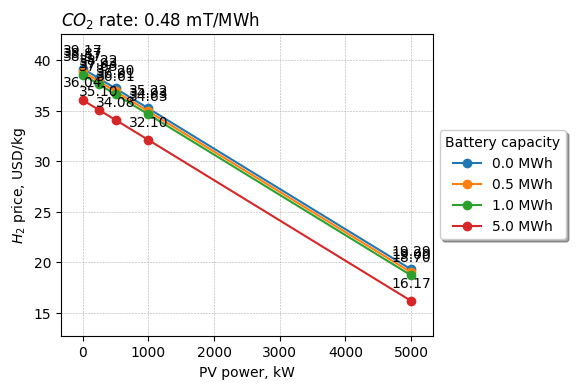

*********************************************
*********************************************
CO2 per kWh upper bound:  1


PV power                                    
                      0.001    240.000  500.000  1000.000 5000.000
Bat capacity 0.001       39.17    38.22     37.2    35.22    19.29
             500.000     38.87    37.93    36.91    34.93     19.0
             1000.000    38.57    37.63    36.61    34.63     18.7
             5000.000    36.04     35.1    34.08     32.1    16.17

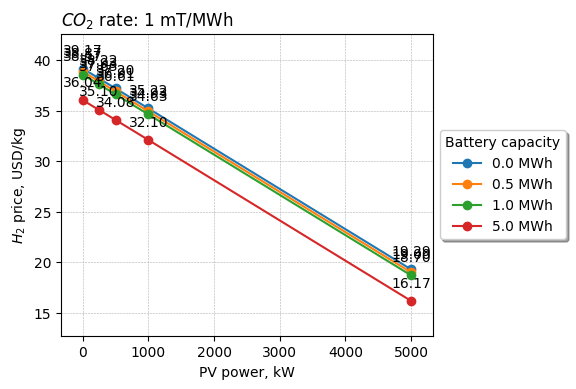

In [188]:
scheduler_results_output(*CAISO_scheduler_calculation(params_dict_1), params_dict_1, price_provider="CAISO")

Grid CaPex 6935474.7
Battery MW vs capex 0 0.0
Solar MW vs capex 0 0.0
Lyser MW vs capex 20000 23923675.93
capex_price 30859150.63
opex_price 30901257.72759979
discounted_volume
Grid CaPex 6935474.7
Battery MW vs capex 1 5073.78
Solar MW vs capex 0 0.0
Lyser MW vs capex 20000 23923675.93
capex_price 30864224.41
opex_price 75091988690.96465
discounted_volume
Grid CaPex 6935474.7
Battery MW vs capex 2 10147.56
Solar MW vs capex 0 0.0
Lyser MW vs capex 20000 23923675.93
capex_price 30869298.189999998
opex_price 46777531.710543126
discounted_volume
Grid CaPex 6935474.7
Battery MW vs capex 3 15221.35
Solar MW vs capex 0 0.0
Lyser MW vs capex 20000 23923675.93
capex_price 30874371.98
opex_price 92820125.64600626
discounted_volume
Grid CaPex 6935474.7
Battery MW vs capex 4 20295.13
Solar MW vs capex 0 0.0
Lyser MW vs capex 20000 23923675.93
capex_price 30879445.759999998
opex_price 217567204.9222628
discounted_volume
Grid CaPex 6935474.7
Battery MW vs capex 0 0.0
Solar MW vs capex 1 3147.34
L

Grid CaPex 6935474.7
Battery MW vs capex 4 20295.13
Solar MW vs capex 4 12589.36
Lyser MW vs capex 20000 23923675.93
capex_price 30892035.119999997
opex_price -21109528.907389052
discounted_volume
Grid CaPex 6935474.7
Battery MW vs capex 0 0.0
Solar MW vs capex 0 0.0
Lyser MW vs capex 20000 23923675.93
capex_price 30859150.63
opex_price 40928401.86309449
discounted_volume
Grid CaPex 6935474.7
Battery MW vs capex 1 5073.78
Solar MW vs capex 0 0.0
Lyser MW vs capex 20000 23923675.93
capex_price 30864224.41
opex_price 40726555.3846565
discounted_volume
Grid CaPex 6935474.7
Battery MW vs capex 2 10147.56
Solar MW vs capex 0 0.0
Lyser MW vs capex 20000 23923675.93
capex_price 30869298.189999998
opex_price 39919168.663517974
discounted_volume
Grid CaPex 6935474.7
Battery MW vs capex 3 15221.35
Solar MW vs capex 0 0.0
Lyser MW vs capex 20000 23923675.93
capex_price 30874371.98
opex_price 36891468.45923011
discounted_volume
Grid CaPex 6935474.7
Battery MW vs capex 4 20295.13
Solar MW vs capex 

PV power                                    
                       0.01     1000.00  5000.00  30000.00 60000.00
Bat capacity 0.001         None     None     None     None     1.53
             1000.000      None     None     None     None     1.52
             5000.000      None     None     None     None     1.46
             20000.000     None     None     None      3.3     1.25
             60000.000     None     None     None     2.43     0.68

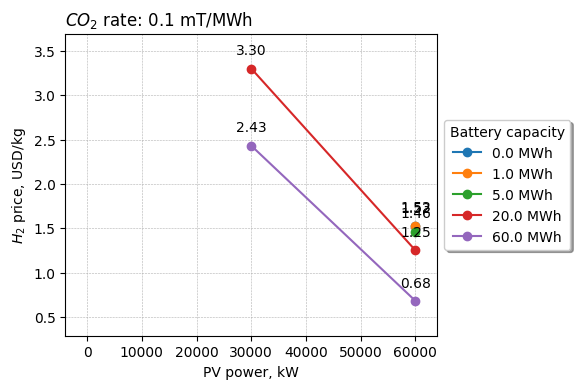

*********************************************
*********************************************
CO2 per kWh upper bound:  0.48


PV power                                    
                       0.01     1000.00  5000.00  30000.00 60000.00
Bat capacity 0.001         5.02     4.96     4.73     3.28     1.53
             1000.000      5.01     4.95     4.72     3.26     1.52
             5000.000      4.95     4.89     4.66     3.21     1.46
             20000.000     4.74     4.68     4.45     2.99     1.25
             60000.000     4.18     4.12     3.88     2.43     0.68

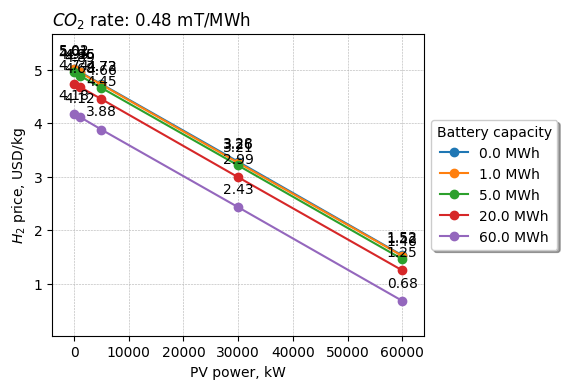

*********************************************
*********************************************
CO2 per kWh upper bound:  1


PV power                                    
                       0.01     1000.00  5000.00  30000.00 60000.00
Bat capacity 0.001         5.02     4.96     4.73     3.28     1.53
             1000.000      5.01     4.95     4.72     3.26     1.52
             5000.000      4.95     4.89     4.66     3.21     1.46
             20000.000     4.74     4.68     4.45     2.99     1.25
             60000.000     4.18     4.12     3.88     2.43     0.68

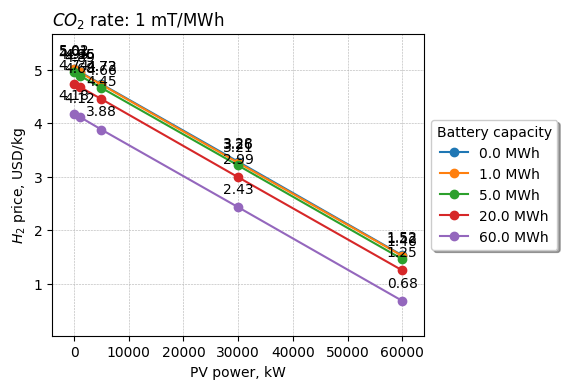

In [189]:
scheduler_results_output(*CAISO_scheduler_calculation(params_dict_2), params_dict_2, price_provider="CAISO")

In [ ]:
scheduler_results_output(*PGE_scheduler_calculation(params_dict_1), params_dict_1, price_provider="PGE")

In [ ]:
scheduler_results_output(*PGE_scheduler_calculation(params_dict_2), params_dict_2, price_provider="PGE")

IndentationError: expected an indented block after function definition on line 123 (4012199328.py, line 125)

## old things below

In [ ]:
with open("calculations for CAISO.csv", 'w', newline='') as f:
    f.write("H2 kg price " + str(params_dict["lyz_daily_demand_kg"]) + " kg daily demand")
    for co2_upper_bound in range(len(params_dict["aim_co2"])):
        f.write("\n\nCO2 per kWh upper bound:" + str(params_dict["aim_co2"][co2_upper_bound]) + "\n")
        output_matrix[co2_upper_bound].to_csv(f)

## Single calculation

In [ ]:
m, result = scheduler(pv_rated_power=400, lyz_rated_power=300, bat_capacity=1000, bat_c_rate=0.32,
                      aim_co2=0.2, lyz_daily_demand_kg=73, 
                      df_energy_price=df_energy_price, df_pv=df_pv, df_co2_rate=df_co2_rate)

In [ ]:
# Processing results

total_lyz_kg = m.lyz_daily_demand_kg.value * 31
total_price_from_grid = sum(m.grid_price[i] * m.grid_power[i].value * 1 / INTERVALS_PER_HOUR for i in m.times)
kg_price = round(total_price_from_grid / total_lyz_kg, 2)
if result.solver.termination_condition == TerminationCondition.infeasible: kg_price = 'inf'

bat_cycles = int(round((m.bat_capacity[0].value - m.bat_capacity[n_intervals].value) / (2 * BAT_TOTAL_CAPACITY * BAT_DEGRADATION_PER_CYCLE), 0))

co2_rate = round(sum(m.co2_rate[i] * m.grid_power[i].value * 1 / INTERVALS_PER_HOUR for i in m.times) / (H2_KWH_PER_KG * total_lyz_kg), 3)

print("kg price = ", kg_price)
print("bat cycles = ", bat_cycles)
print("co2 rate per kg H2 = ", co2_rate)

################
#####~plot~#####
################

var_list = (m.grid_power, m.lyz_power, m.bat_charge, m.bat_power)


plt.rcParams['figure.figsize'] = [8, 12]

fig = plt.figure()
fig.subplots_adjust(hspace=0.9)

ax1 = fig.add_subplot(3 + len(var_list), 1, 1)
ax1.plot(m.grid_price)
ax1.title.set_text('Grid price')

ax2 = fig.add_subplot(3 + len(var_list), 1, 2, sharex=ax1)
ax2.plot(m.pv_power)
ax2.title.set_text('PV power')

ax3 = fig.add_subplot(3 + len(var_list), 1, 3, sharex=ax1)
ax3.plot(m.co2_rate)
ax3.title.set_text('CO2_rate')

subplot_n = 4

for var in var_list:
    ax99 = fig.add_subplot(3 + len(var_list), 1, subplot_n, sharex=ax1)
    ax99.plot([var[index].value for index in var])
    ax99.title.set_text(var)
    
    subplot_n += 1

plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib import colors as mcolors


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

def cc(arg):
    return mcolors.to_rgba(arg, alpha=0.6)

xs = params_dict["pv_rated_power"]
zs = params_dict["bat_capacity"]
ys = []
verts = []
for z in range(len(zs)):
    ys = output_matrix[0].loc[("Bat capacity", params_dict["bat_capacity"][z])]
    verts.append(list(zip(xs, ys)))

print(verts)

poly = PolyCollection(verts, facecolors=[cc('r'), cc('g'), cc('b'), cc('y')], edgecolors=(0,0,1,1))
poly.set_alpha(0.7)
ax.add_collection3d(poly, zs=zs, zdir='y')

#ax.legend()
ax.set_xlim3d(0, 1000)
ax.set_zlim3d(-3, 2)
ax.set_ylim3d(500, 3500)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(elev=20., azim=-35)

#plt.show()

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

pio.renderers.default = 'notebook'

def triangulate_histogtam(x, y, z):
   
    if len(x)  != len(y) != len(z) :
        raise ValueError("The  lists x, y, z, must have the same length")
    n = len(x)
    if n % 2 :
        raise ValueError("The length of lists x, y, z must be an even number") 
    pts3d = np.vstack((x, y, z)).T
    pts3dp = np.array([[x[2*k+1], y[2*k+1], 0] for k in range(1, n//2-1)])
    pts3d = np.vstack((pts3d, pts3dp))
    #triangulate the histogram bars:
    tri = [[0,1,2], [0,2,n]]
    for k, i  in zip(list(range(n, n-3+n//2)), list(range(3, n-4, 2))):
        tri.extend([[k, i, i+1], [k, i+1, k+1]])
    tri.extend([[n-3+n//2, n-3, n-2], [n-3+n//2, n-2, n-1]])      
    return pts3d, np.array(tri)

bar_color = ['#e763fa', '#ab63fa', '#636efa', '#00cc96']

fig = go.Figure()

# random mat
xs = params_dict["pv_rated_power"]
ys = np.asarray(params_dict["bat_capacity"]).reshape(-1,1).repeat(10,axis=1)
for i in range(len(params_dict["bat_capacity"])):
    print(xs)
    print(ys[i])
    print(output_matrix[0].loc[("Bat capacity", params_dict["bat_capacity"][i])])
#    verts, tri = triangulate_histogtam(xs, ys[i], output_matrix[0].loc[("Bat capacity", params_dict["bat_capacity"][i])])
#    x, y, z = verts.T
#    I, J, K = tri.T
#    fig.add_traces(go.Mesh3d(x=x, y=y, z=z, i=I, j=J, k=K, color=bar_color[m], opacity=0.7))
    
#    fig.add_trace(go.Scatter3d(x=xs,
#                               y=ys[i],
#                               z=output_matrix[0].loc[("Bat capacity", params_dict["bat_capacity"][i])],
#                               mode="lines+markers",
#                               marker=dict(size=4),
#                               surfaceaxis=2,
#                               surfacecolor='#66c2a5')
#                 )
fig.show()